In [82]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Reshape, Conv2DTranspose, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras import Model
import matplotlib.pyplot as plt

In [83]:
tf.__version__

'2.0.0-rc1'

# tensorflow 2 버전을 사용하여 간단한 MNIST gan model 을 작성해 봅니다.

In [84]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [85]:
def normalize(img):
    return (img - 127.5) / 127.5

def denormalize(norm_img):
    return norm_img * 127.5 + 127.5

In [86]:
x_train, y_train = normalize(x_train), normalize(y_train)
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

In [87]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_1 = Conv2D(512, (3, 3), activation='relu')
        self.flatten = Flatten()
        self.dense_1 = Dense(256)
        self.logits = Dense(1)
        
    def call(self, x):
        x = self.conv_1(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = LeakyReLU()(x)
        x = self.logits(x)
        return x
    
discriminator = Discriminator()

In [88]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [89]:
class Generator(Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.dense_1 = Dense(7 * 7 * 1024)
        self.reshape = Reshape((7, 7, 1024))
        self.conv_1 = Conv2DTranspose(512, (3, 3), strides=(1, 1), padding='same')
        self.conv_2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')
        self.conv_3 = Conv2DTranspose(1, (3, 3), strides=(2,2), padding='same', activation='tanh')
        
    def call(self, latent):
        x = self.dense_1(latent)
        x = self.reshape(x)
        x = self.conv_1(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = self.conv_2(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        assert x.shape == (BATCH_SIZE, 14, 14, 256)
        x = BatchNormalization()(x)
        x = self.conv_3(x)
        assert x.shape == (BATCH_SIZE, 28, 28, 1)
        return x
generator = Generator()

In [90]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

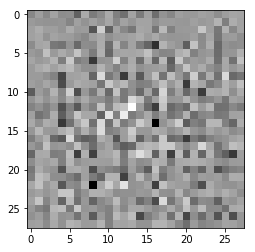

In [91]:
latent = tf.random.normal([BATCH_SIZE, 100])
generated_img = generator(latent)
plt.imshow(generated_img[0,:,:,0], cmap='gray')

In [92]:
decision = discriminator(generated_img)
print (decision)

tf.Tensor(
[[ 8.1035710e-04]
 [ 3.1881640e-04]
 [ 1.6445359e-03]
 [ 2.1021604e-04]
 [-6.0969149e-05]
 [ 7.4563723e-04]
 [ 4.6906283e-04]
 [ 1.4775991e-03]
 [ 1.2410610e-03]
 [ 1.4471679e-03]
 [ 2.3385268e-03]
 [ 7.9606759e-04]
 [ 7.9161604e-04]
 [ 6.2045990e-05]
 [ 1.0952681e-03]
 [ 7.1119552e-04]
 [-1.4559081e-04]
 [ 7.8976667e-04]
 [ 3.5076076e-04]
 [ 9.8982616e-04]
 [ 4.4881273e-04]
 [ 4.8382342e-04]
 [ 1.5134676e-03]
 [ 1.8941304e-03]
 [ 1.4227851e-03]
 [ 1.7405942e-04]
 [ 2.6376343e-03]
 [ 1.2400879e-03]
 [ 5.3448405e-04]
 [ 4.8515241e-04]
 [ 9.8458910e-04]
 [ 1.2651959e-03]], shape=(32, 1), dtype=float32)


In [93]:
def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

In [94]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
get_gen_acc = tf.keras.metrics.BinaryAccuracy(name="gen_acc")
get_disc_acc = tf.keras.metrics.BinaryAccuracy(name="disc_acc")

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_imgs = generator(noise)
        fake_outputs = discriminator(generated_imgs)
        real_outputs = discriminator(images)
        gen_loss = generator_loss(generated_imgs)
        disc_loss = discriminator_loss(real_outputs, fake_outputs)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    gen_acc = get_gen_acc(tf.ones_like(fake_outputs), fake_outputs)
    disc_acc = (get_disc_acc(tf.zeros_like(fake_outputs), fake_outputs) + get_disc_acc(tf.ones_like(real_outputs), real_outputs)) / 2
    print(f"g_loss == {gen_loss:4.2f} / g_accuracy == {gen_acc:4.2f} / d_loss == {disc_loss:4.2f} / d_accuracy == {disc_acc:4.2f}")

In [ ]:
for epoch in range(5):
    for train_imgs in train_dataset:
        train_step(train_imgs)

W1007 17:39:09.977029 4545033664 base_layer.py:1814] Layer discriminator_5 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



g_loss == 0.69 / g_accuracy == 0.00 / d_loss == 1.36 / d_accuracy == 0.75
g_loss == 0.69 / g_accuracy == 0.00 / d_loss == 0.74 / d_accuracy == 0.71
g_loss == 0.69 / g_accuracy == 0.00 / d_loss == 0.75 / d_accuracy == 0.82
g_loss == 0.69 / g_accuracy == 0.00 / d_loss == 0.74 / d_accuracy == 0.87
g_loss == 0.68 / g_accuracy == 0.00 / d_loss == 0.71 / d_accuracy == 0.89
g_loss == 0.68 / g_accuracy == 0.00 / d_loss == 0.67 / d_accuracy == 0.91
g_loss == 0.68 / g_accuracy == 0.00 / d_loss == 0.61 / d_accuracy == 0.93
g_loss == 0.67 / g_accuracy == 0.00 / d_loss == 0.50 / d_accuracy == 0.94
g_loss == 0.67 / g_accuracy == 0.00 / d_loss == 0.36 / d_accuracy == 0.94
g_loss == 0.66 / g_accuracy == 0.00 / d_loss == 0.22 / d_accuracy == 0.95
g_loss == 0.66 / g_accuracy == 0.00 / d_loss == 0.12 / d_accuracy == 0.95
g_loss == 0.66 / g_accuracy == 0.00 / d_loss == 0.05 / d_accuracy == 0.96
g_loss == 0.65 / g_accuracy == 0.00 / d_loss == 0.02 / d_accuracy == 0.96
g_loss == 0.65 / g_accuracy == 0.00 / 

g_loss == 0.31 / g_accuracy == 0.00 / d_loss == 0.00 / d_accuracy == 0.99
g_loss == 0.31 / g_accuracy == 0.00 / d_loss == 0.00 / d_accuracy == 0.99
g_loss == 0.31 / g_accuracy == 0.00 / d_loss == 0.00 / d_accuracy == 0.99
g_loss == 0.31 / g_accuracy == 0.00 / d_loss == 0.00 / d_accuracy == 0.99
g_loss == 0.32 / g_accuracy == 0.00 / d_loss == 0.00 / d_accuracy == 0.99
g_loss == 0.31 / g_accuracy == 0.00 / d_loss == 0.00 / d_accuracy == 0.99
g_loss == 0.31 / g_accuracy == 0.00 / d_loss == 0.00 / d_accuracy == 0.99
g_loss == 0.31 / g_accuracy == 0.00 / d_loss == 0.00 / d_accuracy == 0.99
g_loss == 0.31 / g_accuracy == 0.00 / d_loss == 0.00 / d_accuracy == 0.99
g_loss == 0.31 / g_accuracy == 0.00 / d_loss == 0.00 / d_accuracy == 0.99
g_loss == 0.31 / g_accuracy == 0.00 / d_loss == 0.00 / d_accuracy == 0.99
g_loss == 0.31 / g_accuracy == 0.00 / d_loss == 0.00 / d_accuracy == 0.99
g_loss == 0.31 / g_accuracy == 0.00 / d_loss == 0.00 / d_accuracy == 0.99
g_loss == 0.31 / g_accuracy == 0.00 / 